# Fitting

In [1]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum, spectrum_to_angular, spectrum_to_radial
from analysis import hist_ensamble
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def model_to_csr(model_list):
    csr_list = []
    for model in model_list:
        channel = model.channel
        spectrum = channel_spectrum(channel)

        csr = complex_spacing_ratio(spectrum)
        csr_list.append(csr)
        
    return csr_list
    

In [16]:
path = "../../numerical_experiments/diluted_traceout/data/"

## Retrieve CSR

In [17]:
n = 4

model_integrable_list = pkl.load(open(f'models/integrable_model_{n}_L=10.model', 'rb'))
model_nonintegrable_list = pkl.load(open(f'models/nonintegrable_model_{n}_amend.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)
csr_nonintegrable_list = model_to_csr(model_nonintegrable_list)

## Radial and Angular Distribution

In [18]:
radial_integrable_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_list = spectrum_to_angular(csr_integrable_list)

radial_nonintegrable_list = spectrum_to_radial(csr_nonintegrable_list)
angular_nonintegrable_list = spectrum_to_angular(csr_nonintegrable_list)

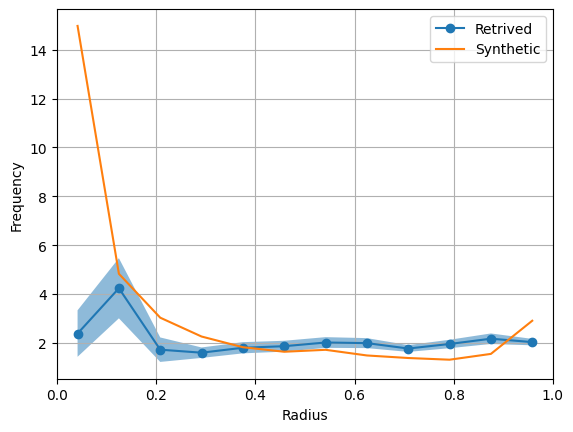

In [19]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.5)
plt.plot(center_bins, hist/center_bins, 'o-', label='Retrived')

center_bins, hist, hist_err = pkl.load(open(path + "radial_integrable.data", 'rb'))
#plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.5)
plt.plot(center_bins, hist/center_bins, '-', label='Synthetic')

plt.xlim(0, 1)
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig('figures/radial_hist_integrable_r2.png')

plt.show()

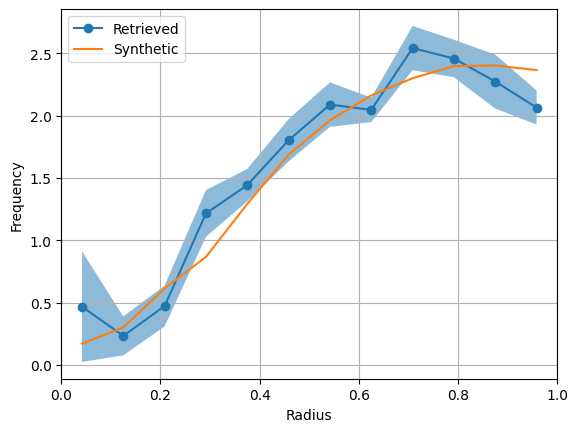

In [20]:
center_bins, hist, hist_err = hist_ensamble(radial_nonintegrable_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.5)
plt.plot(center_bins, hist/center_bins, 'o-', label='Retrieved')

center_bins, hist, hist_err = pkl.load(open(path + "radial_nonintegrable.data", 'rb'))
#plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.5)
plt.plot(center_bins, hist/center_bins, '-', label='Synthetic')

plt.xlim(0, 1)
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig('figures/radial_hist_nonintegrable_r2.png')

plt.show()

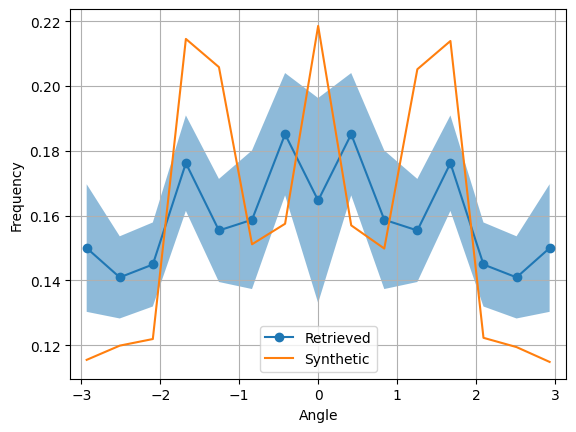

In [21]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

center_bins, hist, hist_err = pkl.load(open(path + "angular_integrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic')
#plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

plt.xlim(-np.pi, np.pi)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.savefig('figures/angular_hist_integrable_r2.png')
plt.show()

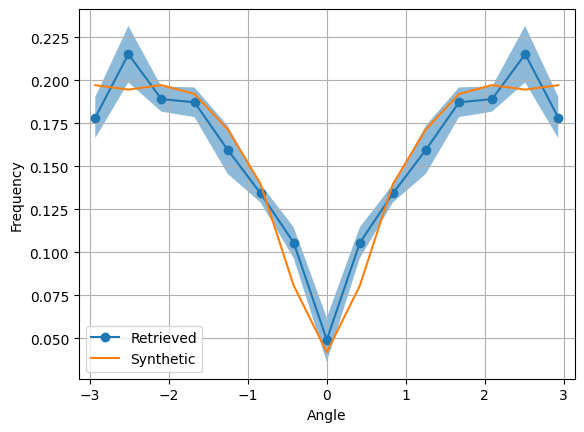

In [22]:
center_bins, hist, hist_err = hist_ensamble(angular_nonintegrable_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)


center_bins, hist, hist_err = pkl.load(open(path + "angular_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic')
#plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.5)

plt.xlim(-np.pi, np.pi)
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.legend()

plt.grid()
plt.savefig('figures/angular_hist_nonintegrable.png')

plt.show()

## More Plots

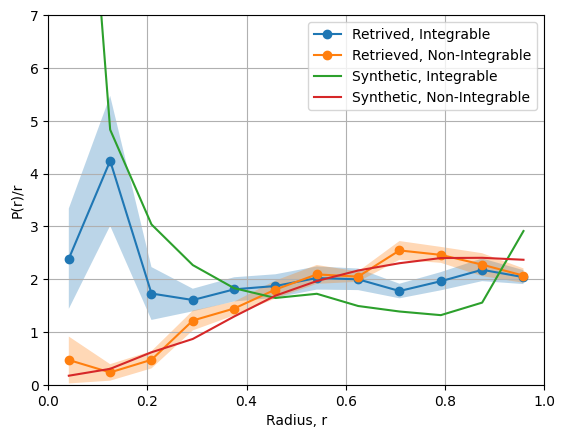

In [23]:
center_bins, hist, hist_err = hist_ensamble(radial_integrable_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.3)
plt.plot(center_bins, hist/center_bins, 'o-', label='Retrived, Integrable')

center_bins, hist, hist_err = hist_ensamble(radial_nonintegrable_list, bins=np.linspace(0, 1, 13))
plt.fill_between(center_bins, (hist-hist_err)/center_bins, (hist+hist_err)/center_bins, alpha=0.3)
plt.plot(center_bins, hist/center_bins, 'o-', label='Retrieved, Non-Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "radial_integrable.data", 'rb'))
plt.plot(center_bins, hist/center_bins, '-', label='Synthetic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "radial_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist/center_bins, '-', label='Synthetic, Non-Integrable')

plt.xlim(0, 1)
plt.ylim(0, 7)
plt.xlabel('Radius, r')
plt.ylabel('P(r)/r')
plt.legend()
plt.grid()
plt.savefig('figures/radial_hist_contrast_r2_L=10.png')

plt.show()

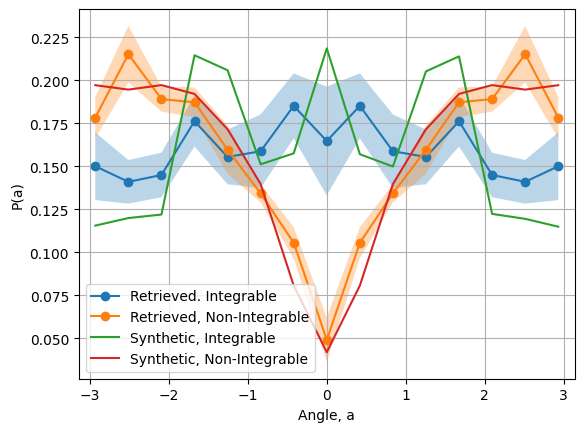

In [24]:
center_bins, hist, hist_err = hist_ensamble(angular_integrable_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved. Integrable')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.3)

center_bins, hist, hist_err = hist_ensamble(angular_nonintegrable_list, bins=np.linspace(-np.pi, np.pi, 16))
plt.plot(center_bins, hist, 'o-', label='Retrieved, Non-Integrable')
plt.fill_between(center_bins, hist-hist_err, hist+hist_err, alpha=0.3)


center_bins, hist, hist_err = pkl.load(open(path + "angular_integrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Integrable')

center_bins, hist, hist_err = pkl.load(open(path + "angular_nonintegrable.data", 'rb'))
plt.plot(center_bins, hist, '-', label='Synthetic, Non-Integrable')

plt.xlim(-np.pi, np.pi)
plt.xlabel('Angle, a')
plt.ylabel('P(a)')
plt.legend()

plt.grid()
plt.savefig('figures/angular_hist_contrast_r2_L=10.png')

plt.show()